# 09. PyTorch Model Deployment

## 9.0 Import libraries

In [ ]:
#10/10/25
import torch, torchvision, os, zipfile, random, requests, sys, pathlib
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from timeit import default_timer as timer
import tqdm.auto as tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from typing import List, Dict, Tuple
import pandas as pd
import gradio as gr

try:
  from torchinfo import summary
except:
  print("No torchinfo found, downloading")
  !pip install -q torchinfo
  from torchinfo import summary

if not os.path.exists('/content/helpers'):
  os.makedirs('/content/helpers')
  sys.path.insert(0, '/content/helpers')
helpers = Path('/content/helpers')

try:
  from helpers import predict, data_setup, set_rand_seed, download_data, engine, utils, vit
except:
  print(f"No helper scripts are found, downloading")
  !git clone https://github.com/UMB200/AI_ML_pytorch_projects.git
  !mv /content/AI_ML_pytorch_projects/helpers/* /content/helpers
  print(f"Remving extra stuff from: {helpers}")
  !rm -rf /content/AI_ML_pytorch_projects

  from helpers import predict, data_setup, set_rand_seed, download_data, engine, utils, vit

## 9.1 Get data


In [ ]:
# device agnostic code setup 10/10/25
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# download data
data_path = download_data.download_data(
    source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination = "pizza_steak_sushi_20_percent")
train_dir = data_path / "train"
test_dir = data_path / "test"

BATCH_SIZE = 32
number_of_classes = 3

No data/pizza_steak_sushi_20_percent dir is found, creating one


## 9.2 FoodVision Mini model deployment goals

**Goals:**
1. Perform with 95% accuracy
2. Fast: as close as to real-time or faster => 30FPS+ or 30ms latency

**Methods-> Build 2 model experiments: **
1. Use EffNetB2 feature extractor
2. Use ViTB16 feature extractro

Then => compare each model and choose the best matching goals


## 9.3 Create EffNetB2 feature extractor

Feature extractor is a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

In [ ]:
# create a model 10/10/25
eff_netb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

eff_netb2_transforms = eff_netb2_weights.transforms()

model_eff_netb2 = torchvision.models.efficientnet_b2(weights = eff_netb2_weights)

### 9.3.1 Function to create EffNetB2 feature extractor

In [ ]:
# create a feature extractor 10/10/25
eff_netb2_model_extracted = engine.feature_extractor(
    model=model_eff_netb2,
    weights=eff_netb2_weights,
    transform=eff_netb2_transforms,
    dropout=0.3,
    model_name="EffNetB2",
    in_features=1408,
    out_features=number_of_classes)

Created new EffNetB2


In [ ]:
# check the model 10/14/25

summary(eff_netb2_model_extracted,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 9.3.2 Create DataLoaders for EffNetB2

In [ ]:
# dataloaders for EffNetB2 10/14/25
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=eff_netb2_transforms)

In [ ]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b7001dae2a0>,
 ['pizza', 'steak', 'sushi'])

### 9.3.3 Train EffNetB2 feature extractor

In [ ]:
start_time = timer()
model_res_effnetb2_output = engine.train(
    model=eff_netb2_model_extracted,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=eff_netb2_model_extracted.parameters(), lr=1e-3),
    epochs=10,
    device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.2f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9886 | train_acc: 0.5396 | test_loss: 0.7449 | test_acc: 0.9534
Epoch: 2 | train_loss: 0.7274 | train_acc: 0.8167 | test_loss: 0.5888 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.6135 | train_acc: 0.8417 | test_loss: 0.5005 | test_acc: 0.9472
Epoch: 4 | train_loss: 0.5290 | train_acc: 0.8375 | test_loss: 0.4442 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.4819 | train_acc: 0.8750 | test_loss: 0.4064 | test_acc: 0.9597
Epoch: 6 | train_loss: 0.4732 | train_acc: 0.8500 | test_loss: 0.3758 | test_acc: 0.9409
Epoch: 7 | train_loss: 0.3585 | train_acc: 0.9375 | test_loss: 0.3771 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3384 | train_acc: 0.9062 | test_loss: 0.3339 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3250 | train_acc: 0.9292 | test_loss: 0.3157 | test_acc: 0.9472
Epoch: 10 | train_loss: 0.3453 | train_acc: 0.9021 | test_loss: 0.2889 | test_acc: 0.9534
Total training time: 56.21 seconds


### 9.3.4 Checking EffNetB2 loss curve

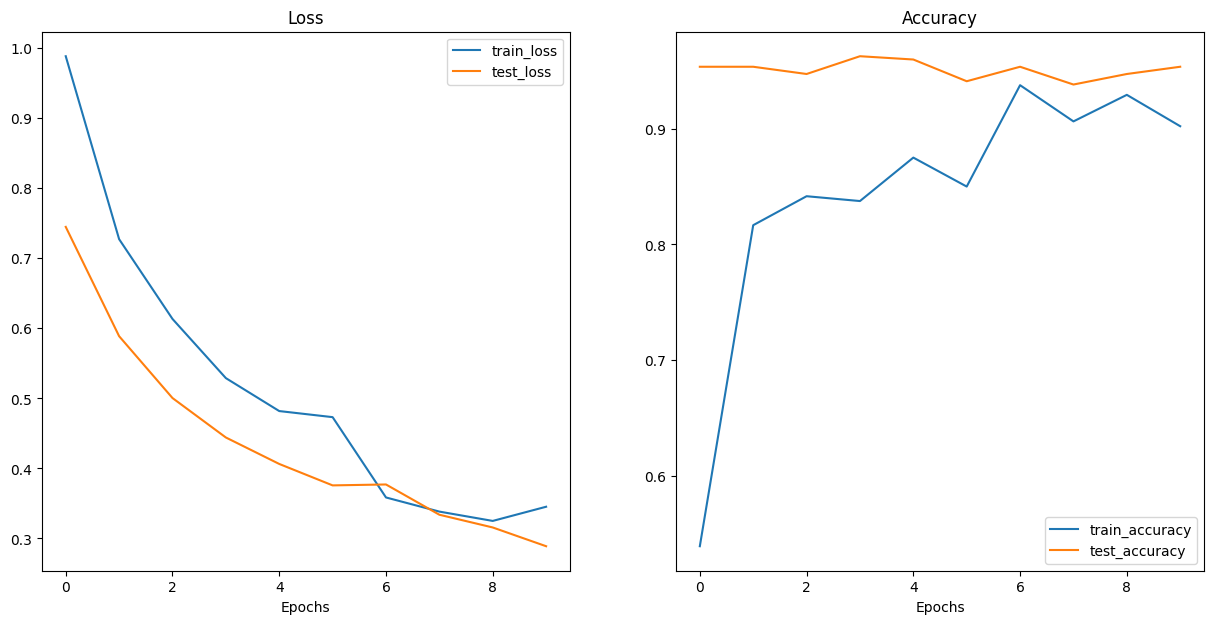

In [ ]:
utils.plot_loss_curves(model_res_effnetb2_output)

### 9.3.5 Save EffNetB2 to a file

In [ ]:
saved_model_path = "models"
effnetb2_saved_model = utils.save_model(model=eff_netb2_model_extracted,
                                        target_dir = saved_model_path,
                                        model_name="09_effnetb2_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_effnetb2_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
def model_size(path:str)-> float:
  model_saved_size = Path(path).stat().st_size / (1024 * 1024)
  return model_saved_size


### 9.3.6 Check the size of EffNetB2 saved model

In [ ]:
effnetb2_saved_model_path = Path("models/09_effnetb2_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth")

effent2_model_size = utils.model_size(effnetb2_saved_model_path)

Model size at:models/09_effnetb2_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth is 29.86 MB


### 9.3.7 EffNetB2 statistics

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_saved_model_params = sum(torch.numel(p) for p in eff_netb2_model_extracted.parameters())
print(f"Number of parameters in EffNetB2: {effnetb2_saved_model_params:,}")

Number of parameters in EffNetB2: 7,705,221


In [ ]:
# Dictionary with model statistics
effnetb2_saved_model_stats = {
    "model_name": "EffNetB2",
    "model_size (MB)": effent2_model_size,
    "test_loss": model_res_effnetb2_output["test_loss"][-1],
    "test_acc": model_res_effnetb2_output["test_acc"][-1],
    "num_of_params": effnetb2_saved_model_params}

effnetb2_saved_model_stats

{'model_name': 'EffNetB2',
 'model_size (MB)': 29.86450481414795,
 'test_loss': 0.2889184981584549,
 'test_acc': 0.953409090909091,
 'num_of_params': 7705221}

## 9.4 Create ViT Model extractor

In [ ]:
#10/15/25
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit_model = torchvision.models.vit_b_16(weights = vit_weights)

vit_transforms = vit_weights.transforms()

for p in vit_model.parameters():
  p.requires_grad = False

vit_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=number_of_classes))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 204MB/s]


In [ ]:
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 9.4.1 Create DatLoaders for ViT

In [ ]:
# dataloaders for ViT 10/15/25
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=vit_transforms)

### 9.4.2 Training Vit

In [ ]:
start_time = timer()
vit_model_trained = engine.train(
    model=vit_model,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=vit_model.parameters(), lr=1e-3),
    epochs=20,
    device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.2f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5724 | train_acc: 0.8187 | test_loss: 0.2324 | test_acc: 0.9631
Epoch: 2 | train_loss: 0.2118 | train_acc: 0.9396 | test_loss: 0.1273 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1461 | train_acc: 0.9521 | test_loss: 0.0965 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1201 | train_acc: 0.9625 | test_loss: 0.0836 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1016 | train_acc: 0.9708 | test_loss: 0.0764 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0888 | train_acc: 0.9771 | test_loss: 0.0705 | test_acc: 0.9847
Epoch: 7 | train_loss: 0.0745 | train_acc: 0.9812 | test_loss: 0.0671 | test_acc: 0.9847
Epoch: 8 | train_loss: 0.0637 | train_acc: 0.9854 | test_loss: 0.0661 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0625 | train_acc: 0.9875 | test_loss: 0.0632 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0492 | train_acc: 0.9917 | test_loss: 0.0646 | test_acc: 0.9722
Epoch: 11 | train_loss: 0.0489 | train_acc: 0.9958 | test_loss: 0.0611 | test_acc: 0.9784
Epoch: 12 | train_l

### 9.4.3 Plot Loss Curve for ViT

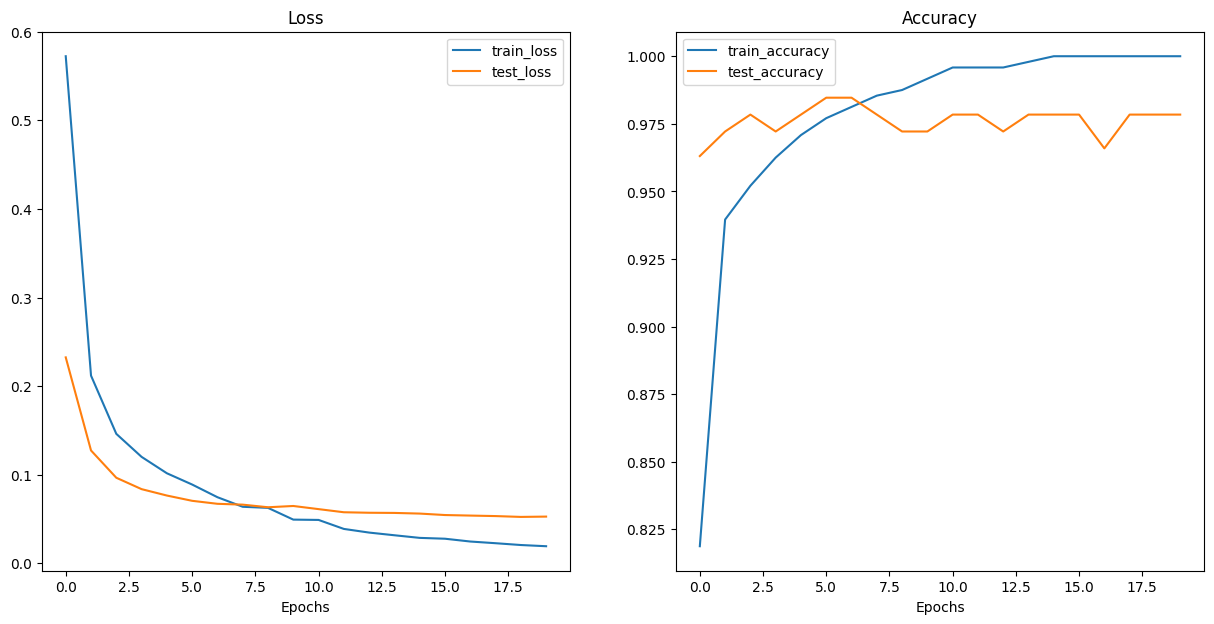

In [ ]:
utils.plot_loss_curves(vit_model_trained)

### 9.4.4 Save Vit Model

In [ ]:
vit_model_saved = utils.save_model(model=vit_model,
                                            target_dir = saved_model_path,
                                            model_name="09_vit_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_vit_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth


### 9.4.5 Get the size of ViT

In [ ]:
vit_saved_model_path = Path("models/09_vit_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth")
vit_model_size = utils.model_size(vit_saved_model_path)

Model size at:models/09_vit_pretrained_feature_extractor_pizza_steak_sushi_20_percent.pth is 327.37 MB


### 9.4.6 ViT statistics  

In [ ]:
# Count number of parameters
vit_model_trained_params = sum(torch.numel(p) for p in vit_model.parameters())
print(f"Number of parameters in ViT: {vit_model_trained_params:,}")

Number of parameters in ViT: 85,800,963


In [ ]:
# Dictionary with model statistics
vit_model_stats = {
    "model_name": "ViT",
    "model_size (MB)": vit_model_size,
    "test_loss": vit_model_trained["test_loss"][-1],
    "test_acc": vit_model_trained["test_acc"][-1],
    "num_of_params": vit_model_trained_params}

vit_model_stats

{'model_name': 'ViT',
 'model_size (MB)': 327.3715181350708,
 'test_loss': 0.05264085093513131,
 'test_acc': 0.978409090909091,
 'num_of_params': 85800963}

## 9.5 Making predictions with trained models and timing results

### 9.5.1 Function to run preds on all data

In [ ]:
# Check how long it takes on average to make preiction
# Function loops through images and stores the result
test_data_path_list = list(Path(test_dir).glob("*/*.jpg"))
def predict_store_av_result(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device=device):

  pred_list = []
  for p in tqdm(paths):
    iteration_pred = {}
    # Get the sample path and ground truth class name
    iteration_pred["image_path"] = p
    ground_truth_class_name = p.parent.stem
    iteration_pred["ground_truth_class_name"] = ground_truth_class_name

    start_time = timer()
    img = Image.open(p)
    img_transformed = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logits = model(img_transformed)
      pred_probs = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_probs, dim=1)
      pred_class_name = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU because Python variables reside on CPU
      iteration_pred["pred_prob"] = round(pred_probs.unsqueeze(0).max().cpu().item(), 4)
      iteration_pred["ground_truth_class_name"] = pred_class_name
      end_time = timer()
      iteration_pred["pred_time"] = round(end_time - start_time, 4)

    iteration_pred["correct"] = ground_truth_class_name == pred_class_name
    pred_list.append(iteration_pred)

  return pred_list


### 9.5.2 Making prediction and timing with EffnetB2

In [ ]:
effnetb2_pred_time = predict_store_av_result(
    paths=test_data_path_list,
    model=eff_netb2_model_extracted,
    transform=eff_netb2_transforms,
    class_names=class_names,
    device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_pred_time_df = pd.DataFrame(effnetb2_pred_time)
effnetb2_pred_time_df.head()

,image_path,ground_truth_class_name,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8946,0.2755,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.5869,0.0996,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.7698,0.0900,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8712,0.0868,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8250,0.0859,True


In [ ]:
# check correct predictions
effnetb2_pred_time_df["correct"].value_counts()

,count
correct,
True,143
False,7


In [ ]:
# find the average time per prediction
effentb2_average_pred_time = effnetb2_pred_time_df["pred_time"].mean()
print(f"Average prediction time for EffNetB2: {effentb2_average_pred_time:.2f} seconds")

Average prediction time for EffNetB2: 0.09 seconds


### 9.5.3 Making prediction and timing with ViT

In [ ]:
vit_pred_time = predict_store_av_result(
    paths=test_data_path_list,
    model=vit_model,
    transform=vit_transforms,
    class_names=class_names,
    device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the time
vit_pred_time_df = pd.DataFrame(vit_pred_time)
vit_pred_time_df.head()

,image_path,ground_truth_class_name,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9975,0.4953,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9970,0.3405,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9888,0.3354,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9991,0.3529,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9928,0.3285,True


In [ ]:
# check correct number of prediction
vit_pred_time_df["correct"].value_counts()

,count
correct,
True,147
False,3


In [ ]:
# find average time per prediction
print(f"Average prediction time for EffNetB2: {effentb2_average_pred_time:.2f} seconds")
vit_average_pred_time = vit_pred_time_df["pred_time"].mean()
print(f"Average prediction time for ViT: {vit_average_pred_time:.2f} seconds")


Average prediction time for EffNetB2: 0.09 seconds
Average prediction time for ViT: 0.37 seconds


In [ ]:
# Adding average time prediction to models stats
effnetb2_saved_model_stats["average_pred_time (seconds)"] = effentb2_average_pred_time
vit_model_stats["average_pred_time (seconds)"] = vit_average_pred_time

effnetb2_saved_model_stats, vit_model_stats

({'model_name': 'EffNetB2',
  'model_size (MB)': 29.86450481414795,
  'test_loss': 0.2889184981584549,
  'test_acc': 0.953409090909091,
  'num_of_params': 7705221,
  'average_pred_time (seconds)': np.float64(0.088818)},
 {'model_name': 'ViT',
  'model_size (MB)': 327.3715181350708,
  'test_loss': 0.05264085093513131,
  'test_acc': 0.978409090909091,
  'num_of_params': 85800963,
  'average_pred_time (seconds)': np.float64(0.36649600000000004)})

## 9.6.0 Comparing model results, prediction time and size

In [ ]:
# Add effnetb2_saved_model_stats and vit_model_stats to dataframe for visual comparison and format numbers to a reasable view, size in MB with 2 decimals, test_loss and test_acc to %, num_of_params to format as number and prediction time to 2 digits
model_stats_df = pd.DataFrame([effnetb2_saved_model_stats, vit_model_stats])
model_stats_df

,model_name,model_size (MB),test_loss,test_acc,num_of_params,average_pred_time (seconds)
0,EffNetB2,29.864505,0.288918,0.953409,7705221,0.088818
1,ViT,327.371518,0.052641,0.978409,85800963,0.366496


In [ ]:
# Format the DataFrame for better readability
model_stats_df_formatted = model_stats_df.copy()

model_stats_df_formatted["model_size (MB)"] = model_stats_df_formatted["model_size (MB)"].apply(lambda x: f"{x:.0f}")
model_stats_df_formatted["test_loss"] = model_stats_df_formatted["test_loss"].apply(lambda x: f"{x:.0%}")
model_stats_df_formatted["test_acc"] = model_stats_df_formatted["test_acc"].apply(lambda x: f"{x:.0%}")
model_stats_df_formatted["num_of_params"] = model_stats_df_formatted["num_of_params"].apply(lambda x: f"{x:,}")
model_stats_df_formatted["average_pred_time (seconds)"] = model_stats_df_formatted["average_pred_time (seconds)"].apply(lambda x: f"{x:.2f}")

display(model_stats_df_formatted)

,model_name,model_size (MB),test_loss,test_acc,num_of_params,average_pred_time (seconds)
0,EffNetB2,30,29%,95%,"7,705,221",0.09
1,ViT,327,5%,98%,"85,800,963",0.37


In [ ]:
# Compare ViT to EffNetB2 accross different characteristics
vit_to_effnetb2_df = pd.DataFrame(data=(model_stats_df.set_index("model_name").loc["ViT"] / model_stats_df.set_index("model_name").loc["EffNetB2"]),
                                  columns=["ViT to EffNetB2 ratios"]).T
vit_to_effnetb2_df

,model_size (MB),test_loss,test_acc,num_of_params,average_pred_time (seconds)
ViT to EffNetB2 ratios,10.961893,0.1822,1.026222,11.135432,4.126371


EffNetB2 shows better results considering size of the model

### 9.6.1 Visualize speed vs performance tradeoff

Saved diagram to a file


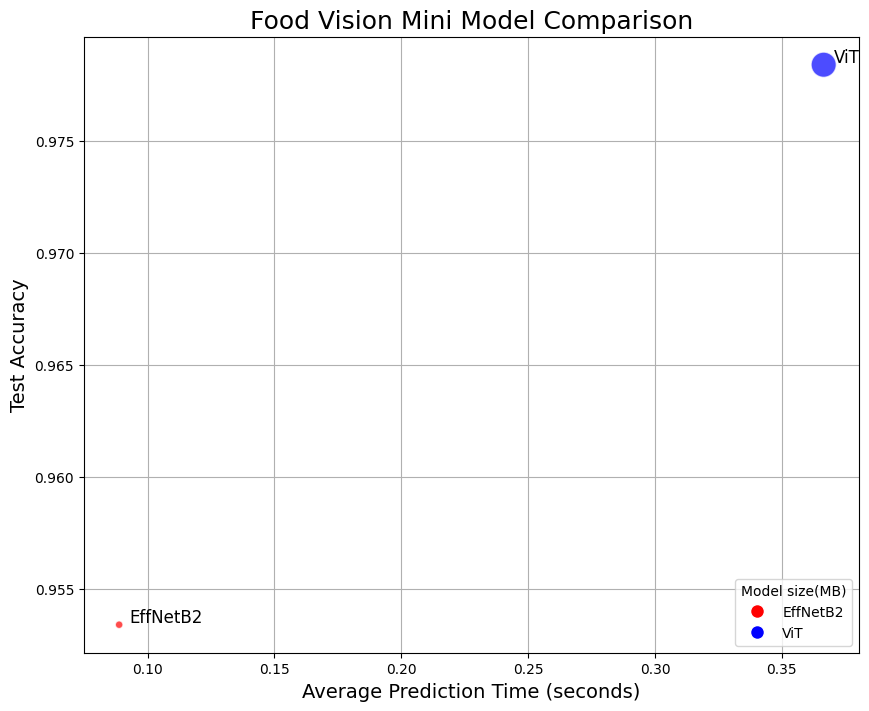

In [ ]:
# Create a diagram from model comparison dataframe
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    data= model_stats_df,
    x = "average_pred_time (seconds)",
    y = "test_acc",
    c=["red", "blue"],
    s="model_size (MB)",
    alpha=0.7,
    edgecolors="w",
    linewidths=0.9)

# add title, labels
ax.set_title ("Food Vision Mini Model Comparison", fontsize=18)
ax.set_xlabel("Average Prediction Time (seconds)", fontsize=14)
ax.set_ylabel("Test Accuracy", fontsize=14)
ax.tick_params(axis="both", labelsize=10)
ax.grid(True)


# create legend
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)

color_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="EffNetB2"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="blue", markersize=10, label="ViT")
]
color_legend = ax.legend(handles=color_handles,
                         title="Model size(MB)",
                         loc="lower right")

# Save the diagram
d_path = '/content/diagram'
if not os.path.exists(d_path):
  os.makedirs(d_path)
  sys.path.insert(0, d_path)

# annote model names
for inx, row in model_stats_df.iterrows():
  ax.annotate(
      text=row["model_name"],
      xy=(row["average_pred_time (seconds)"]+0.004, row["test_acc"]+0.00009),
      size=12)

plt.savefig(Path(d_path) / "09-foodvision-mini-inference-speed-vs-performance.jpg")
print(f"Saved diagram to a file")

# show the diagram
plt.show()

## 9.7.0 Create Gradio Demo

In [ ]:
# import gradio 10/16/2025
import gradio as gr
gr.__version__

'5.49.0'

### 9.7.1 Gradio overview

'gr.Interface(fn, inputs, outputs)'

### 9.7.2 Creating a function to map our inputs and outputs

In [ ]:
# Hardcode EffNetB2 on CPU because Gradio is free for cpu only. GPU has to be premium
eff_netb2_model_extracted.to(device="cpu")
next(iter(eff_netb2_model_extracted.parameters())).device

device(type='cpu')

In [ ]:
# Perform transformartion and prediction on image and returns prediction and time taken

def predicte_and_transform(img) -> Tuple[Dict, float]:
  """Perform transformartion and prediction on image and returns prediction and time taken
  """
  start_time = timer()
  img = eff_netb2_transforms(img).unsqueeze(0)
  eff_netb2_model_extracted.eval()
  with torch.inference_mode():
    pred_prob = torch.softmax(eff_netb2_model_extracted(img), dim=1)
  pred_lbl_and_prob = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
  pred_time = round(timer() - start_time, 4)
  return pred_lbl_and_prob, pred_time